In [2]:
import numpy as np
import matplotlib.pyplot as plt
import starry

import exoplanet as exo


In [3]:
starry.__version__

'1.0.0.dev3'

In [4]:
map = starry.Map(ydeg=20, udeg=2, rv=True, lazy=False)


In [5]:
time, vels, verr = np.loadtxt('../data/transit.vels', usecols=[0,1,2], unpack=True)
time -= 2458706.5

In [6]:
Prot = 2.85             # days
P = 8.1387              # days
t0 = 0.168
e = 0.0                   
w = 0.0
inc = 90.0


vsini = 18.3 * 1e3      # m /s
r = 0.06472             # In units of Rstar
b = -0.40               # I want it to transit in the South!
a = 19.42               # In units of Rstar
u1 = 0.95
u2 = 0.20
obl = -0
gamma = -15
gammadot = 100
gammadotdot = 800

veq = vsini / np.sin(inc * np.pi / 180.0)



Compiling `rv`... Done.
/home/bmontet/anaconda3/envs/p35/lib/python3.5/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


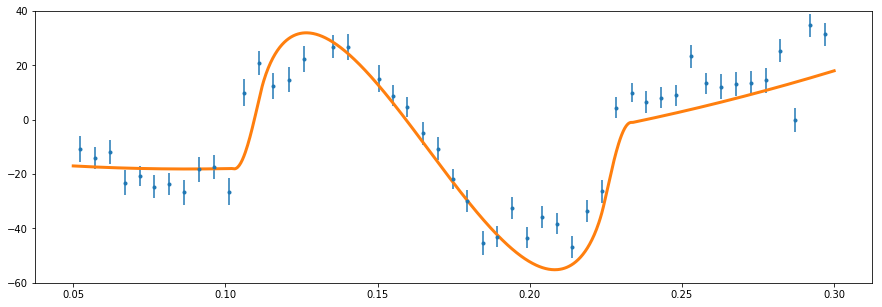

In [7]:
map.reset()
map.inc = inc
map.obl = obl
#map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
map[1:] = [u1, u2]
map.veq = veq

orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 


t = np.linspace(0.05, 0.30, 1000)


f = (t - t0)/P*2*np.pi
I = np.arccos(b/a)

zo = a*np.cos(f) 
yo = -a*np.sin(np.pi/2+f)*np.cos(I)
xo = a*np.sin(f)*np.sin(I)


theta = 360.0 / Prot * t

rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
rv += gamma + gammadot*(t-0.15) + gammadotdot*(t-0.15)**2
    

plt.figure(figsize=(15,5))
plt.plot(t, rv, "C1", lw=3)
plt.errorbar(time, vels, yerr=verr, fmt='.')
plt.ylim(-60, 40);

Compiling `render`... Done.


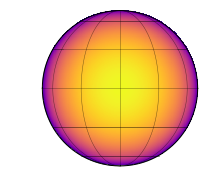

In [8]:
map.show(rv=False)

In [9]:
from scipy.optimize import minimize

In [10]:
tuse = time + 0.0
euse = verr + 0.0
vuse = vels + 0.0


def rmcurve(params):
    
    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)
    
    f = (tuse - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tuse

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(tuse-0.15)
    
    
    var_good = (euse**2 + jitter_good**2)
    var_bad  = (euse**2 + jitter_bad**2)
    gooddata = -0.5*q*(np.sum((rv-vuse)**2/var_good + np.log(2*np.pi*var_good)))
    baddata  = -0.5*(1-q)*(np.sum((rv-vuse)**2/var_bad + np.log(2*np.pi*var_bad)))
    lnprob = gooddata + baddata

    print(-1*lnprob)
    return -1*lnprob



In [11]:
def plot_rmcurve(params):

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)
    
    f = (t - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)

    theta = 360.0 / Prot * t

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(t-0.15)

    plt.figure(figsize=(15,5))
    plt.plot(t, rv, "C1", lw=3)
    plt.errorbar(time, vels, yerr=verr, fmt='.')
    plt.ylim(-50, 40);
    plt.show()


195.50309503453116


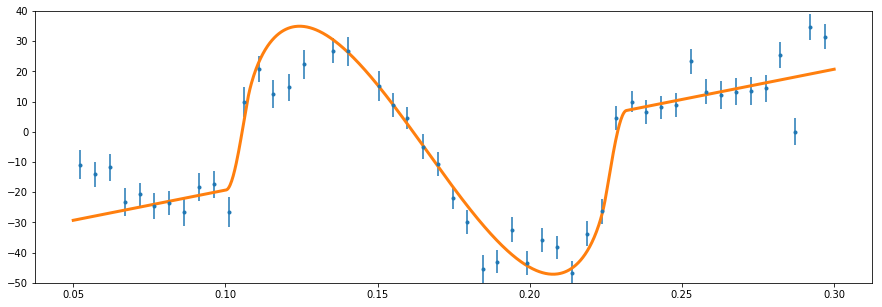

In [15]:
inputs = np.array([19300, 0.0588, -0.09, 20.79, 1.0, 0.00, 0.0, -9.3, 200.1, 1.0, 10.0, 0.8, 0.166])

bnds = ((12000, 24000), (0.04, 0.07), (-1.0, 0.0), (15,25), (0,1),(0,1), (0,90), (-20,20),(50,300), (0.0, 2.0), (2.0, 20.0), (0.0, 1.0), (0.16, 0.175))
rmcurve(inputs)

plot_rmcurve(inputs)

In [61]:
res = minimize(rmcurve, inputs, method='L-BFGS-B', bounds=bnds)

209.39452397305382
209.39452397307605
209.3945372536324
209.39452328082206
209.39452390793087
209.39452364315858
209.39452382455846
209.39452397768233
209.39452397691014
209.3945239735357
209.3945239127083
209.39452397571264
209.39452435576777
209.3946398466152
228.37829076490797
228.37829076489496
228.3782806271293
228.37829080731314
228.37829085794394
228.37829106500087
228.37829095404763
228.378290765842
228.37829076452786
228.37829076670138
228.37829076490797
228.37829069012642
228.3782932403449
228.37830679326697
207.31802301163577
207.3180230115957
207.3179958221283
207.31802210501465
207.3180231981862
207.31802361585136
207.3180235049819
207.3180230173926
207.3180230153264
207.31802301412426
207.31802295223233
207.31802301553194
207.31802344160087
207.31803134506612
191.17986890988777
191.17986890989374
191.17987317367385
191.1798682962176
191.1798689855157
191.1798691151412
191.17986914465172
191.17986891271664
191.17986891194766
191.17986891083285
191.17986886806202
191.179868

177.43365653952952
177.43365653952515
177.43365655449205
177.43365682334198
177.4336505014857
176.58679778437573
176.5867977843838
176.5868026710202
176.58679774131457
176.58679780506796
176.58679773837017
176.58679777778204
176.58679778378192
176.58679778213764
176.5867977844335
176.58679778437573
176.58679780080408
176.58679803309462
176.58679069852607
175.74543891906254
175.7454389190632
175.74543936519925
175.74543885850397
175.74543892445698
175.74543885915384
175.74543889517807
175.74543891901484
175.74543891744457
175.74543891922255
175.74543891906254
175.74543893696224
175.7454391348062
175.74543950871958
175.74161416141848
175.74161416141897
175.7416144964251
175.7416141014079
175.7416141670821
175.7416141022005
175.7416141379581
175.74161416138386
175.7416141598079
175.7416141615822
175.74161416141848
175.741614179323
175.74161437715807
175.74161431300945
175.73872454768525
175.73872454768542
175.73872468768178
175.73872448815587
175.73872455394542
175.73872448964306
175.7387

172.55680398669614
172.55680398758565
172.55680398719602
172.55680400370701
172.5568042077205
172.5568060702853
174.0300893649462
174.03008936494146
174.03008631584535
174.0300892474637
174.0300893209309
174.03008918778337
174.03008925374164
174.03008936530415
174.03008936501217
174.03008936522613
174.0300893649462
174.03008937553042
174.03008967868251
174.03009319489664
172.52683348787764
172.52683348787494
172.52683178640507
172.52683338278777
172.52683348515788
172.5268334539837
172.52683347880705
172.52683348808125
172.5268334874438
172.52683348825346
172.52683348787764
172.52683350408498
172.52683371228312
172.5268358261633
172.37539419004136
172.37539419004005
172.3753934282456
172.37539408627882
172.3753941882064
172.37539415698708
172.37539418236085
172.37539419013953
172.37539418951005
172.37539419038245
172.37539419004136
172.37539420597298
172.3753944133668
172.37539549482582
171.9811053556515
171.98110535565434
171.98110733865767
171.9811052535652
171.9811053500324
171.9811

169.11592079180227
169.11592079097517
169.1159207904936
169.11592079148218
169.1159207909562
169.11592079098148
169.115921016828
169.11592068277236
169.11586205814456
169.11586205814422
169.1158620644162
169.11586188609112
169.1158620587213
169.11586203239284
169.11586205888725
169.1158620581706
169.11586205770914
169.1158620586733
169.11586205814456
169.11586205815485
169.11586228405517
169.11586203690695
169.1158551910061
169.11585519100575
169.11585519562968
169.11585501886535
169.1158551915445
169.1158551650718
169.1158551916209
169.1158551910323
169.11585519058306
169.115855191535
169.1158551910061
169.1158551910182
169.11585541691477
169.1158551655374
169.1158412451458
169.11584124514542
169.11584124408682
169.11584107288746
169.11584124562447
169.11584121908993
169.11584124567338
169.1158412451727
169.11584124474538
169.11584124567543
169.1158412451458
169.1158412451704
169.11584147105808
169.11584120347695
169.1158217383635
169.11582173836317
169.11582173535012
169.115821566046

In [62]:
# vsini, r, b, a, u1, u2, obl, gamma, gammadot = params
print(res.x.tolist())

[18300.000694254188, 0.05547141969352626, 0.0, 19.68324498361166, 1.0, 0.4899343573176554, 13.334277619349276, -8.953381958341861, 199.99161276815494, 0.0, 6.224280878732736, 0.0, 0.16545818868306356]


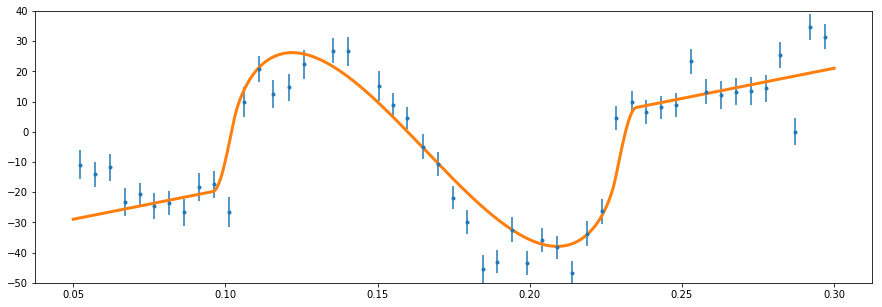

In [68]:
test = res.x + 0.0
#test[0] = 20000
test[4] = 1.0
test[5] = 0.0
plot_rmcurve(test)

In [81]:
orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=0.4, ecc=e, omega=w, r_star=1.0) 

x, y, z = orbit.get_relative_position(tuse)


In [82]:
xp = x.eval()
yp = y.eval()
zp = z.eval()

In [83]:
(zp**2+yp**2+xp**2)**0.5

array([19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42])

In [84]:
a

19.42

In [85]:
tuse = np.arange(-4, 4, 0.1)

f = (tuse - t0)/P*2*np.pi
I = np.arccos(b/a)


In [106]:


zpos = a*np.cos(f) 
ypos = -a*np.sin(np.pi/2+f)*np.cos(I)
xpos = a*np.sin(f)*np.sin(I)

In [108]:
zpos-zp

array([-4.10861147e-03, -4.11988110e-03, -4.10660824e-03, -4.06887196e-03,
       -4.00689705e-03, -3.92105270e-03, -3.81185031e-03, -3.67994039e-03,
       -3.52610875e-03, -3.35127177e-03, -3.15647097e-03, -2.94286680e-03,
       -2.71173171e-03, -2.46444261e-03, -2.20247260e-03, -1.92738228e-03,
       -1.64081037e-03, -1.34446401e-03, -1.04010856e-03, -7.29557091e-04,
       -4.14659590e-04, -9.72919255e-05,  2.20655316e-04,  5.37288094e-04,
        8.50720200e-04,  1.15908449e-03,  1.46054402e-03,  1.75330295e-03,
        2.03561731e-03,  2.30580532e-03,  2.56225745e-03,  2.80344598e-03,
        3.02793415e-03,  3.23438464e-03,  3.42156763e-03,  3.58836804e-03,
        3.73379223e-03,  3.85697389e-03,  3.95717923e-03,  4.03381130e-03,
        4.08641361e-03,  4.11467280e-03,  4.11842052e-03,  4.09763446e-03,
        4.05243843e-03,  3.98310167e-03,  3.89003722e-03,  3.77379949e-03,
        3.63508091e-03,  3.47470783e-03,  3.29363561e-03,  3.09294292e-03,
        2.87382531e-03,  

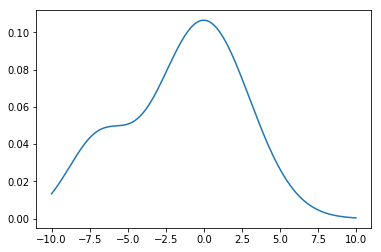

In [49]:
x = np.arange(-10, 10, 0.02)
sigma1 = 3
mu1 = 0

sigma2 = 2
mu2 = -7
g1 = 0.8/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 = 0.2/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))

plt.plot(x, g1+g2)
#plt.plot(x, g1)
#plt.plot(x, g2)


In [41]:
print(np.sum(g1*0.02), np.sum(g2*0.02))

0.9991418412528934 1.0000000000000213
